In [5]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import requests
import tempfile
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1
from functools import partialmethod

from sklearn import preprocessing
import qgrid

In [2]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

In [3]:
sql = '''
with feed as (
   select picture_id, feed_type, tags 
    from `goingtoclouds.feed.all_feed` 
    where feed_type = 'base_feed'

    union all 
    select picture_id, feed_type, tags 
    from `goingtoclouds.feed.all_feed` 
    where feed_type = 'daily_feed' and tags is not null 
    
    union all 
    select distinct picture_id, feed_type, "daily" as  tags 
    from `goingtoclouds.feed.all_feed` 
    where feed_type = 'daily_feed' 

    union all 
    select picture_id, feed_type, tags 
    from `goingtoclouds.feed.all_feed` 
    where feed_type = 'bonus_feed' and tags is not null 

    union all 
    select distinct picture_id, feed_type, "bonus" as  tags 
    from `goingtoclouds.feed.all_feed` 
    where feed_type = 'bonus_feed'
)

select customer_user_id, total_finished_pics, tags, 
    count(distinct picture_id) as tag_finished_pics, 
    count(distinct picture_id)/total_finished_pics as finished_share
from (
    SELECT customer_user_id, a.picture_id, tags,
        count(distinct a.picture_id) over(partition by customer_user_id) as total_finished_pics
    FROM `goingtoclouds.aggregated_data.picture_finish` as a
    left join feed as b
    on a.picture_id=b.picture_id
    where tags is not null and customer_user_id is not null
    and country != 'Belarus' and customer_user_id not in (0, 31))
group by customer_user_id, total_finished_pics, tags
'''
fin_pics = client.query(sql, project=project_id).to_dataframe()

In [7]:
scaled_dt = pd.pivot_table(fin_pics, values='finished_share', index=['customer_user_id', 'total_finished_pics'], 
                           columns=['tags']).reset_index()
scaled_dt.replace(np.nan, 0, inplace = True)

In [8]:
# Шкалирование данных
scaled_dt['scaled_total_finished_pics'] = preprocessing.scale(scaled_dt.total_finished_pics)

X = scaled_dt.loc[:, ~scaled_dt.columns.isin(['customer_user_id', "total_finished_pics"])]
X = X.astype(np.float16)
X = X.values

In [13]:
# !pip install qgrid
# !jupyter nbextension enable --py --sys-prefix qgrid
# !jupyter nbextension enable --py --sys-prefix  widgetsnbextension
# import qgrid

# qgrid_widget = qgrid.show_grid(scaled_dt, show_toolbar=True)
# qgrid_widget

# qgrid_widget.get_changed_df()

### Ищем оптимальное количество кластеров

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

distortions = []
K = range(1,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    cluster_labels = kmeanModel.predict(X) 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

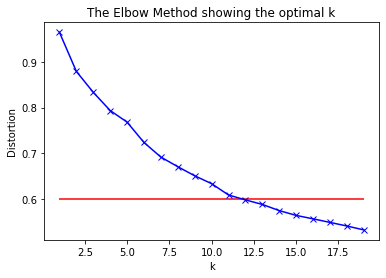

In [38]:
import matplotlib.pyplot as plt

# Plot the elbow
plt.plot(range(1,16, distortions, 'bx-')
plt.hlines(0.6, xmin=1, xmax=19, colors= "red")
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Судя по графику оптимальное количество кластеров - 10-11

In [23]:
kmeanModel = KMeans(n_clusters=3, random_state=10).fit(X)
cluster_labels = kmeanModel.predict(X) 

In [28]:
sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
cluster_labels = kmeanModel.predict(X) 

In [29]:
silhouette_avg = silhouette_score(X, cluster_labels)

In [30]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

KeyboardInterrupt: 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.4387644975296138


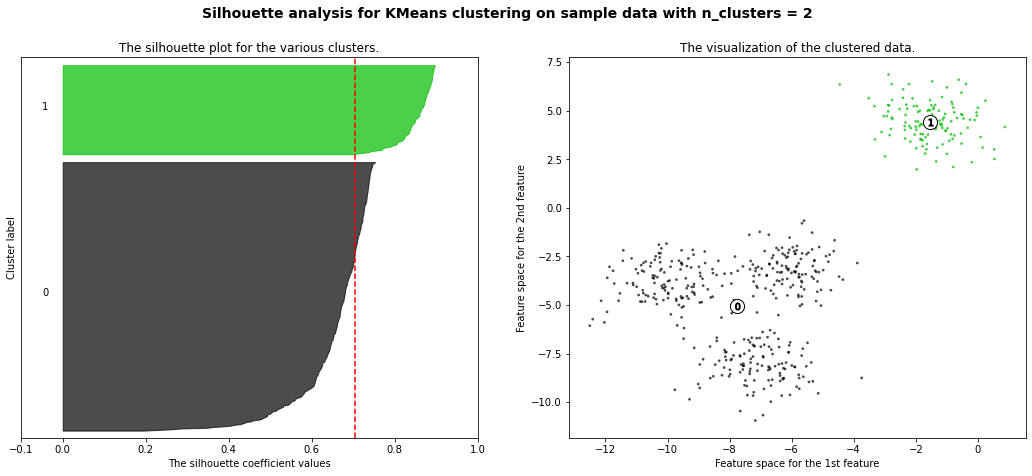

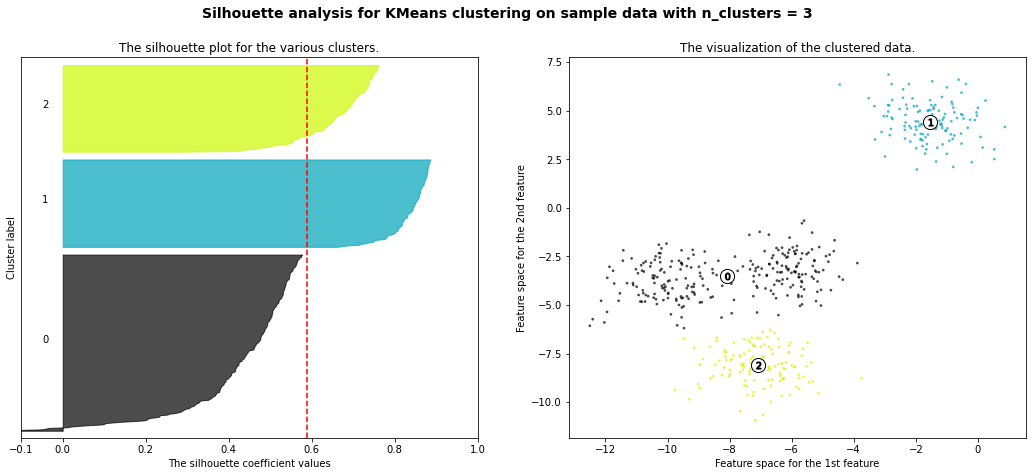

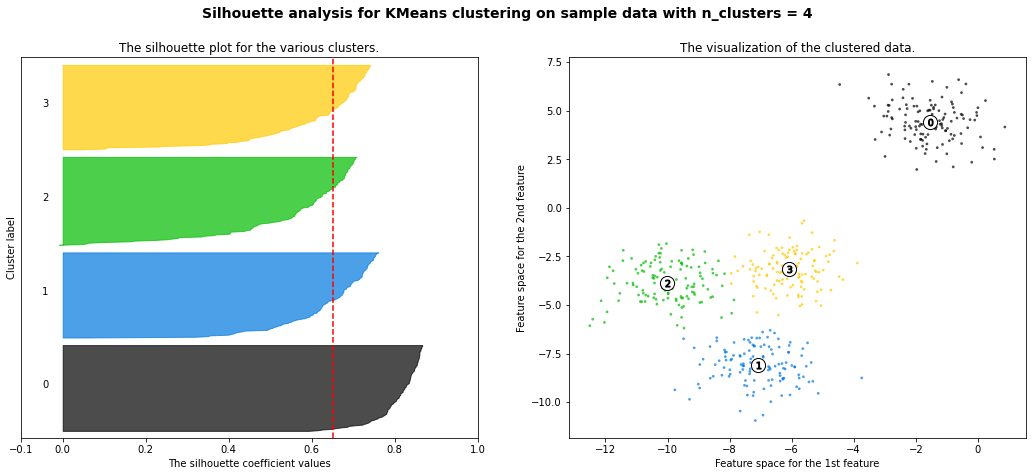

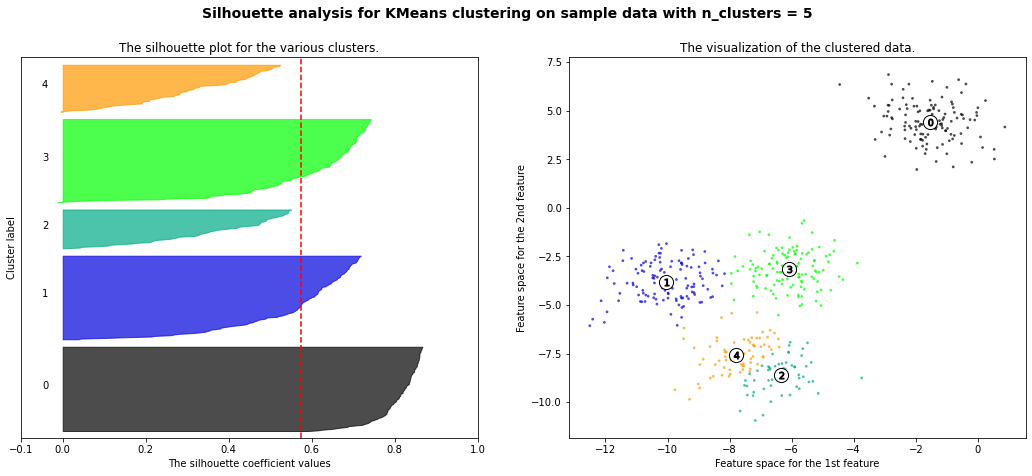

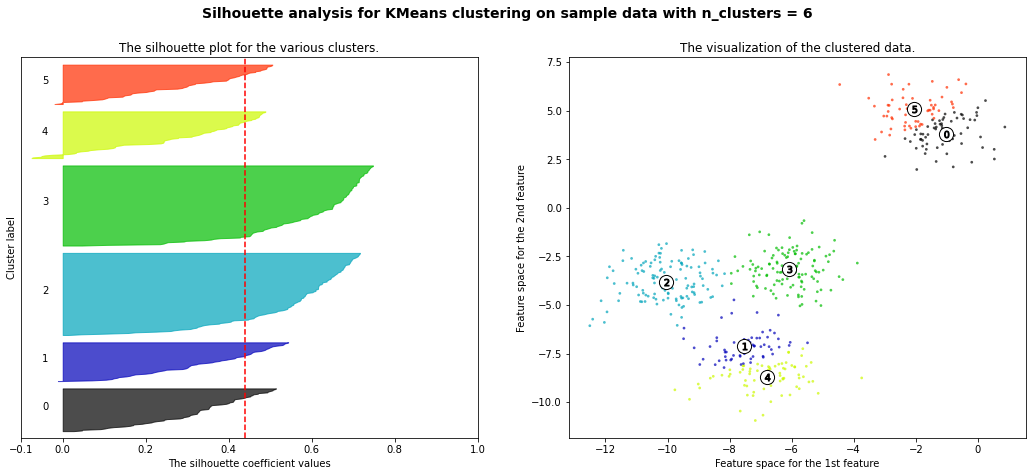

In [40]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = range(2,7)

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Affinity Propagation

In [19]:
from sklearn.cluster import AffinityPropagation

# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
# clusters = unique(yhat)

MemoryError: Unable to allocate 1.37 TiB for an array with shape (433776, 433776) and data type float64

In [42]:
(2**0.5)+(3.5**0.5)

3.285042255760066

In [20]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=10)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)

MemoryError: Unable to allocate 701. GiB for an array with shape (94080592200,) and data type float64

In [21]:
from sklearn.cluster import Birch

model = Birch(threshold=0.01, n_clusters=2)

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

# retrieve unique clusters
clusters = unique(yhat)

AttributeError: '_CFSubcluster' object has no attribute 'sq_norm_'

In [ ]:
from sklearn.cluster import DBSCAN


# define the model
model_ = DBSCAN(eps=0.30, min_samples=5)
# fit model and predict clusters
yhat_ = model_.fit_predict(X)
# retrieve unique clusters
clusters_ = unique(yhat_)